# Fisherova-Kolmogorovova rovnice s radiálně symetrickou počáteční podmínkou

*KMA/VPM2*

*Jan Půlpán*


Fisherova-Kolmogorovova rovnice ve 2D pro neznámou funkci $u(x,y,t)$ má tvar

$$u_t = \Delta{u} + u(1-u)$$ 

Pokud uvažujeme radiálně symetrickou počáteční podmínku, lze pomocí transformace do polárních souřadnic $u(x,y) \longrightarrow u(r,\rho), x=r\cos{\rho}, y=r\sin{\rho}$ přepsat rovnici do tvaru

$$u_t = u_{rr} + \frac{1}{r}u_r + u(1-u).$$

Tuto rovnici neumíme převést na ODR v proměnné $z=r-ct$ stejně jako v případě 1D rovnice, můžeme ale přesto pomocí analýzy jejího chování dojít k zajímavým zjištěním týkajících se rychlosti šíření vlny.

Oproti 1D rovnici nám přibyl advekční člen $\frac{1}{r}u_r$, který v závislosti na velikosti $r$ mění rychlost vlny. Pro $r\rightarrow \infty$ je advekční člen zanedbatelný a platí tedy $u_t \approx u_{rr} + u(1-u)$. Pro velká $r$ se proto rychlost vlny blíží $c\approx 2$. Pro malá $r$ snižuje advekční člen rychlost vlny. S rostoucím časem a tím i ploměrem $r$ tak rychlost vlny $c$ stoupá asymptoticky k $c=2$. Difuzní člen $u_{rr}$ vznikající vlnu vyhladí a postupně ji radiálně symetricky "roztahuje", člen $u(1-u)$ zajistí pro $u<1$ logistický růst k $u=1$. Pro počáteční $u>1$ bude naopak $u$ klesat k $1$.

Z předchozího je tedy patrné, že rychlost vlny $c$ je závislá na poloměru $r$ a není konstatní jako v 1D případě. Jakým způsobem závislá se pokusíme zjistit pomoc numerických experimentů.

## Numerické experimenty s různými počátečními podmínkami

Rovnici řešíme ve formě $u_t = \Delta{u} + u(1-u)$ pro různé počáteční podmínky.

Rychlost vlny $c$ se pokusíme odhadnout z numerického řešení. Ve vybraných časových krocích $t_i$ získáme hodnotu $r_i = u_i^{-1}(k)$, kde $k$ je daná konstanta. Posloupnost $r_i$ definuje funkci růstu poloměru vlny. Abychom zjistili rychlost šíření $c$ stačí ji tedy derivovat. Kvůli numerickému řešení musíme být ale velmi opatrní jak. Použití dopředné diference nestačí a výsledky jsou bohužel velmi nepřesné. Pokud použijeme centrální diferenci výsledky nám již něco ukážou.

Na následujících obrázcích jsou výsledky numerických experimentů pro různé počáteční podmínky a různé parametry numerického řešení.


In [1]:
import pde
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 12})

def fksolve(domain_size=100.,
           grid_size = 500,
           max_time = 9,   # 10 steps, as count starting 0
           dt = 0.001,
           tracker_int = 0.05,
           iv_size = 101,
           iv_func = lambda x, y: 1,
           slice_num = 10,
           ylim = 1.1,
           u_level = 0.2):   # u value to approximate the speed at

    # grid 
    grid = pde.CartesianGrid([[0, domain_size]]*2, grid_size)
    
    # axisymmetric initial values
    X = np.linspace(-1.,1.,iv_size)
    Y = np.linspace(-1.,1.,iv_size)
    Z = np.zeros((iv_size,iv_size))
    for i in range(0,iv_size): 
        for j in range(0,iv_size):
            if X[i]**2+Y[j]**2<1:
                Z[i,j] = iv_func(X[i],Y[j])
    x0 = np.zeros(grid.shape)
    lo = int((grid_size - iv_size)/2)
    hi = lo+iv_size
    x0[lo:hi, lo:hi] = Z

    state = pde.ScalarField(grid,x0) #.smooth()
    
    # solve the problem
    eq = pde.PDE(
        {"u": "laplace(u) + u*(1-u)"},
    )
    storage = pde.MemoryStorage()
    tracker = ['progress', storage.tracker(interval=tracker_int)] 
    result = eq.solve(state, t_range=max_time, dt=dt, tracker=tracker)
    
    
    # plot results
    
    fig = plt.figure(figsize=(20,18))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    # initial value
    state.plot(cmap='Blues', clim=(0,1), ax=ax1, title='Počáteční podmínka')
    # solution
    result.plot(cmap='Blues', clim=(0,1), ax=ax2,\
                title='Řešení $u(x,y,t)$ v čase $t={}$'.format(max_time))
    
    # solution slices in time
    xty = int(len(storage.times) / (slice_num-1))
    
    ts = np.array(storage.times)
    t_size = len(ts)
    
    rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])
    half_grid_size = int(grid_size/2)
  
    cmap = plt.get_cmap('Blues')
    colors = cmap(np.linspace(.4, 1.0, t_size))    
    for t in range(t_size)[0::xty]: #, color in zip(ts, colors):
        ax3.plot(rs, storage.data[t][half_grid_size], color=colors[t],\
                 label='t={:.1f}'.format(t*tracker_int))

    ax3.set_xlabel('y')
    ax3.set_ylabel('u({:.0f},y,t)'.format(domain_size/2))
    ax3.set_title('Řezy řešení $u(x,y,t)$ v $x={:.0f}$'.format(domain_size/2))
    ax3.set_xlim([0,domain_size])
    ax3.set_ylim([0,ylim])   
    ax3.legend()
   
    # wave speed 
    r_t = np.zeros(t_size)
    for t in range(t_size):
        r_data = storage.data[t][half_grid_size]
        rs_inx = np.argwhere(r_data>=u_level)
        r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) \
        *((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
        
    ax4.plot(ts[0::xty], np.gradient(r_t[0::xty], ts[0::xty]), 'o:', color=colors[-1])
    ax4.set_title('Rychlost šíření vlny $c$ pro řezy vlevo')
    ax4.set_xlabel('t')
    ax4.set_ylabel('c(x,y,t)')

    plt.show()

    return result, storage, grid


### Bump funkce

Základní počáteční podmínkou pro nás bude bump funkce $\Phi$, která je radiálně symetrická, je hladká $\Phi \in C^{\infty}$ a je funkcí s kompaktním supportem. Více viz třeba [Wikipedia](https://en.wikipedia.org/wiki/Bump_function).

Z následující simulace je patrný vliv logistického růstu, kdy profil řešení stoupá k $1$, i vliv difuze, která vlnu roztahuje do stran. Díky převládajícímu růstu je rychlost vlny $c$ nejprve menší, později se blíží k hodnotě $c\approx 2$.

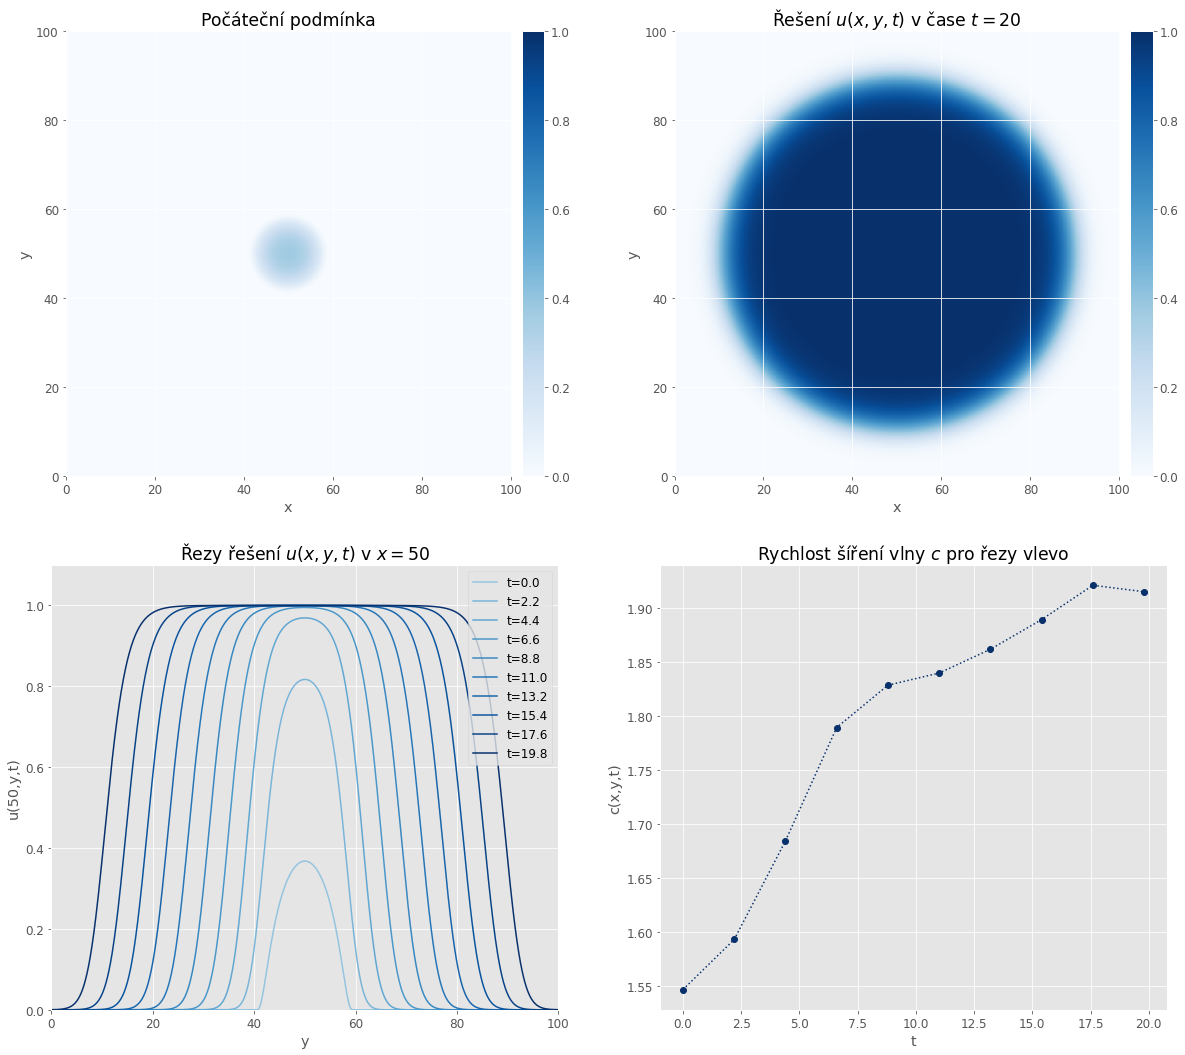

In [2]:
result, storage, grid = fksolve(max_time = 20, 
                                iv_size = 200,
                                iv_func = lambda x,y: np.exp(-1/(1-x**2-y**2)),
                                dt = .001,
                                domain_size = 100,
                                grid_size = 1000,
                                tracker_int = .05,
                               )

### Bump funkce s maximem v $1$

Rozdíl oproti předchozímu případu je ve "velikosti" počáteční podmínky. Díky advekčnímu členu nejprve hodnota funkce téměř neznatelně poklesne, ale velmi brzy začne díky logistickému růstu opět stoupat. Rychlost vlny se opět z počátečních menších hodnot ustálí na $c \approx 2$. 

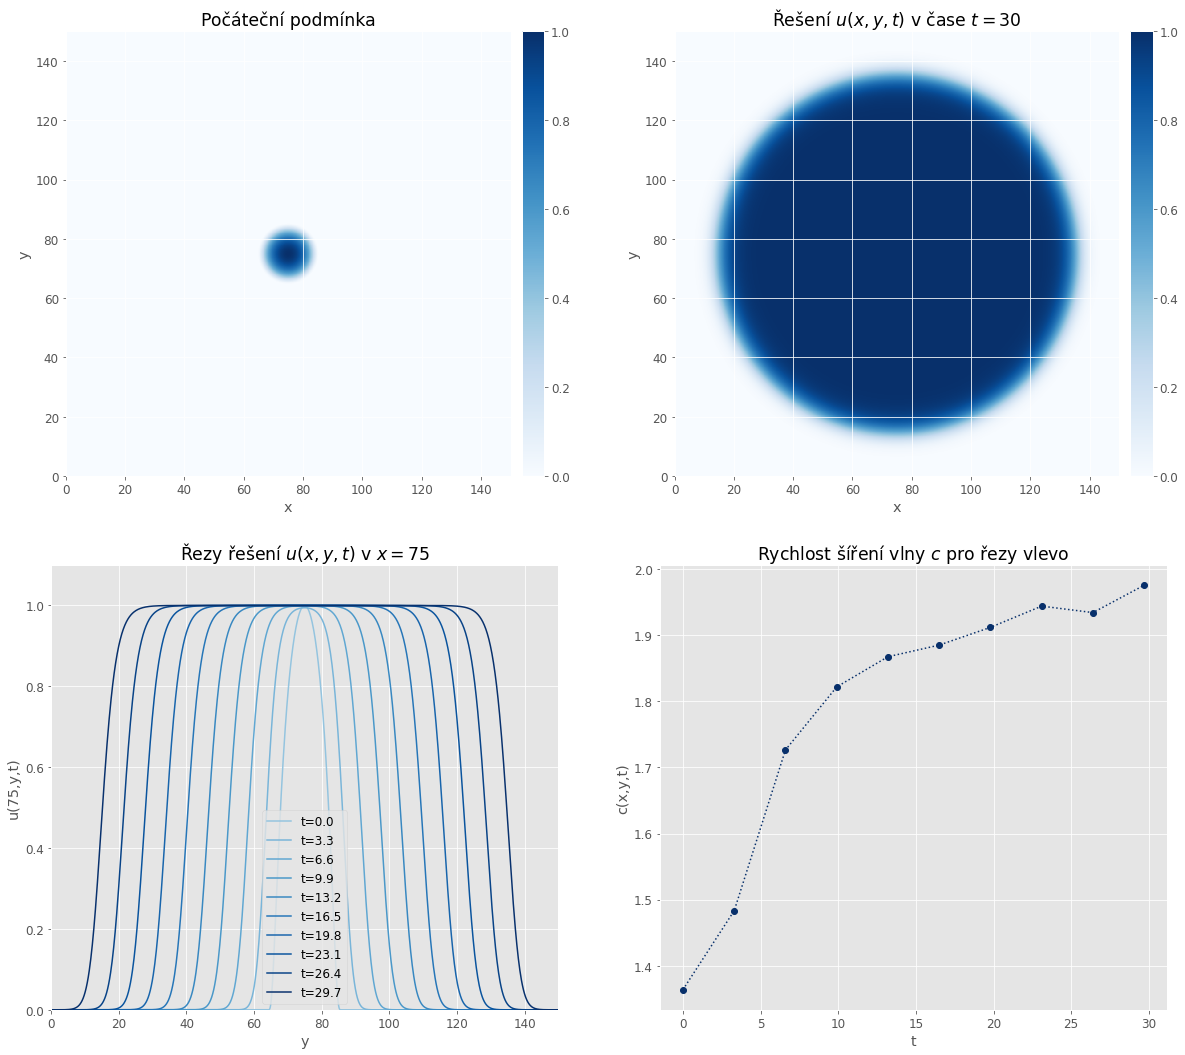

In [3]:
#bump function, size 120, size 1
result, storage, grid = fksolve(iv_size=149,
                         iv_func=lambda x,y: np.exp(1-1/(1-x**2-y**2)),
                         domain_size=150,
                         max_time=30,
                         grid_size=1000
                         )

### Skoková funkce

Co se stane, pokud použijeme nehladkou funkci? Z následujícího experimentu je vidět, že nic zásadního. Stejně jako v případě bump funkce se funkce díky diffuznímu členu okamžitě vyhladí a začne růst až k hodnotě $1$. Rychlost opět stoupá a blíží se hodnotě $c=2.$

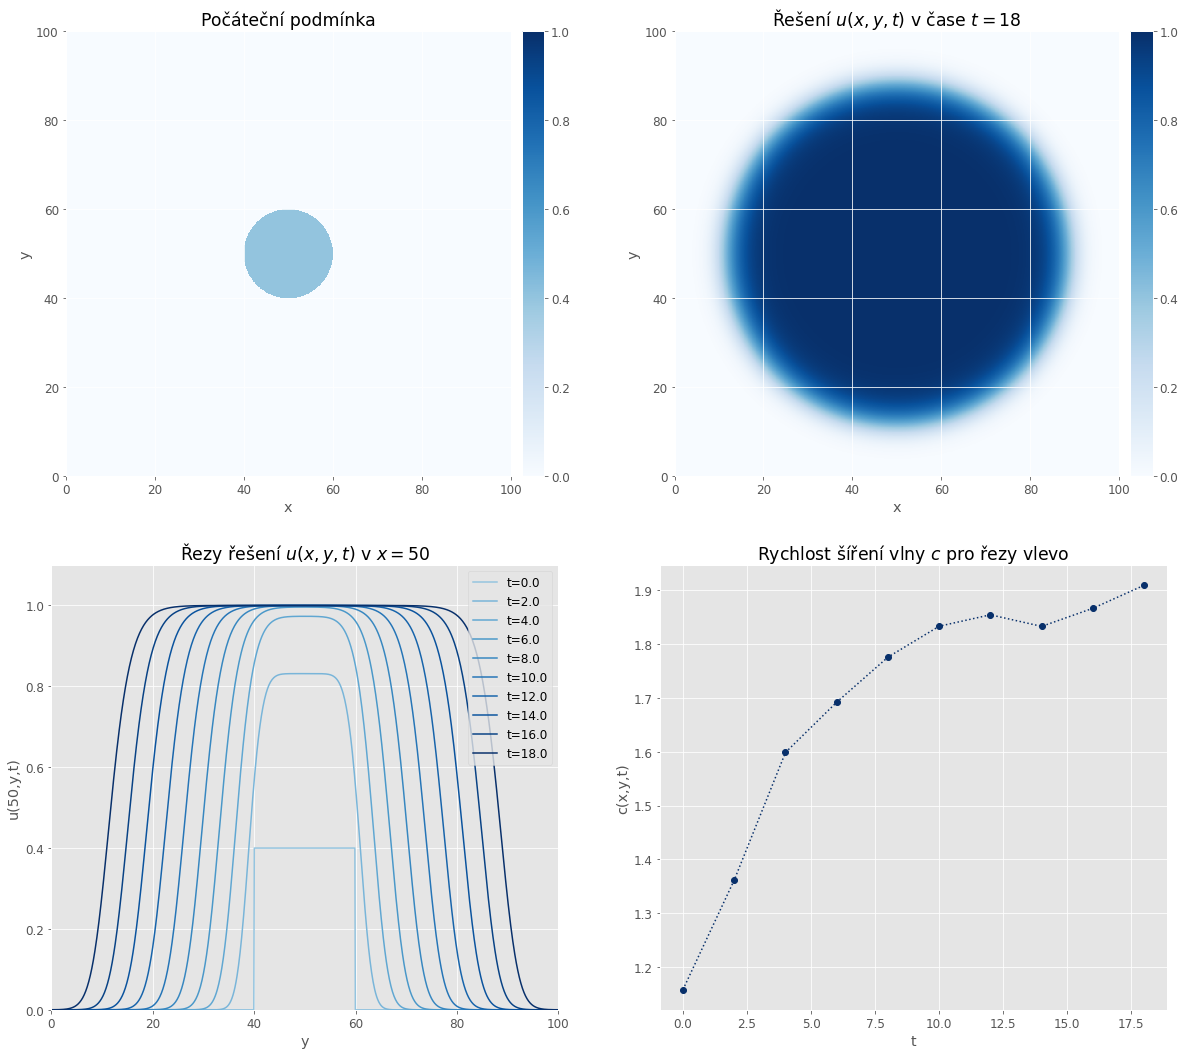

In [4]:
result, storage, grid = fksolve(iv_func = lambda x,y: .4,
                                max_time = 18,
                                iv_size = 201,
                                grid_size = 1000
                               )

### Skoková funkce s velmi malým poloměrem

Pokud je počáteční $r$ velmi malé, advekční člen nejprve sníží hodnotu funkce, převládne difuzní člen. Teprve s dostatečně velkým $r$ začne $u$ znovu růst. Rychlost šíření vlny $c$ je nejprve velmi vysoká, kvůli převládajícímu difuznímu členu, sníží se ve chvíli, kdy převládá evoluční člen a začne se blížit k $c\approx 2$.

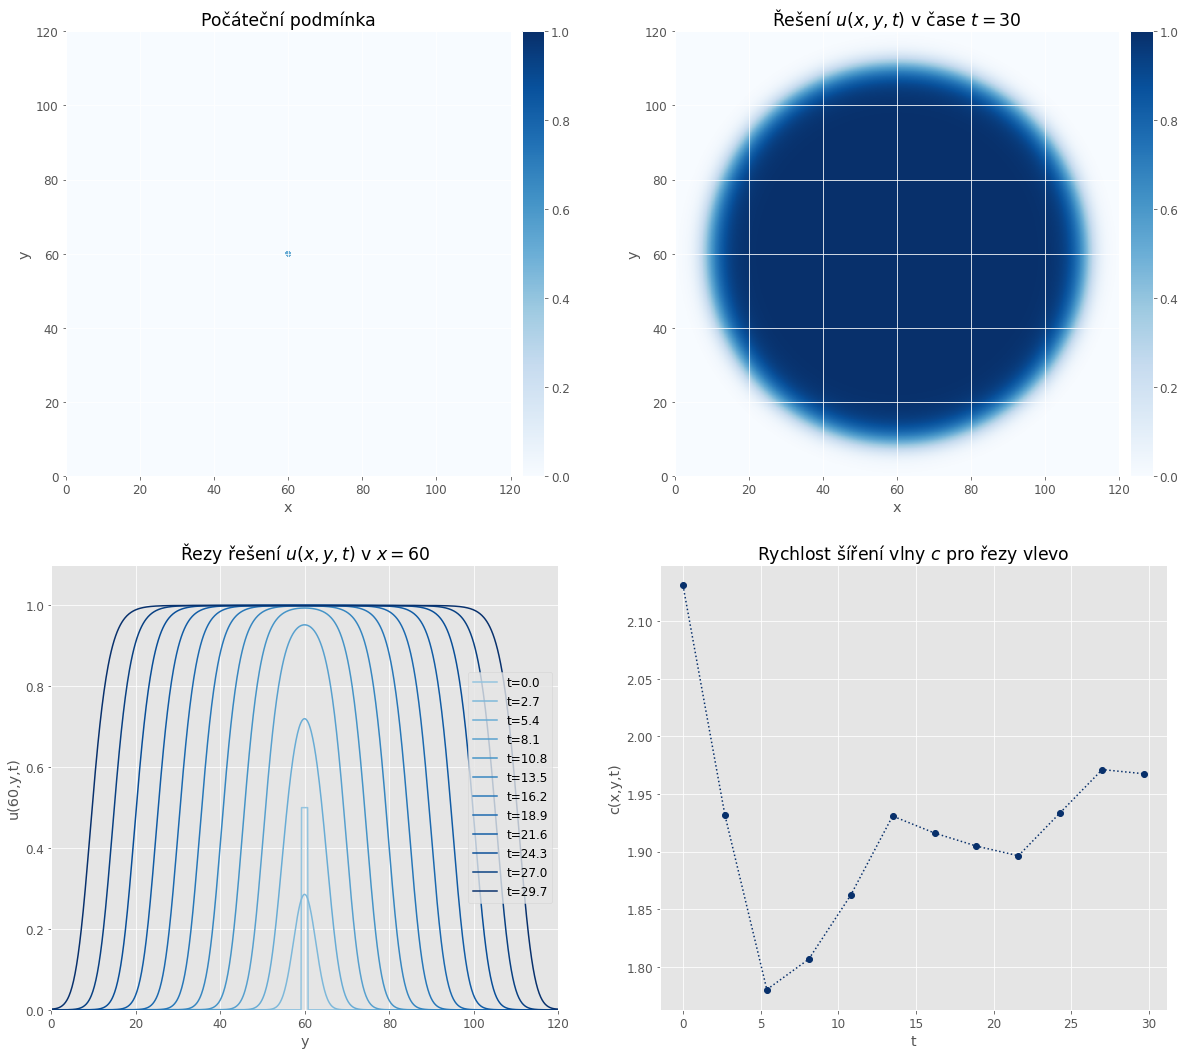

In [5]:
result, storage, grid = fksolve(iv_func= lambda x,y: .5, 
                                iv_size=15, 
                                max_time=30, 
                                u_level=0.01,
                               slice_num = 12,
                               domain_size = 120,
                               grid_size = 1000,
                               )

### Bump funkce s lokální perturbací

Jen pro zajímavost si ukažme co se stane, pokud na počáteční bump funkci aplikujeme nějakou lokální perturbaci. I takováto počáteční podmínka se rychle vyhladí do standardního tvaru vlny a rychlost šíření je $c \approx 2.$

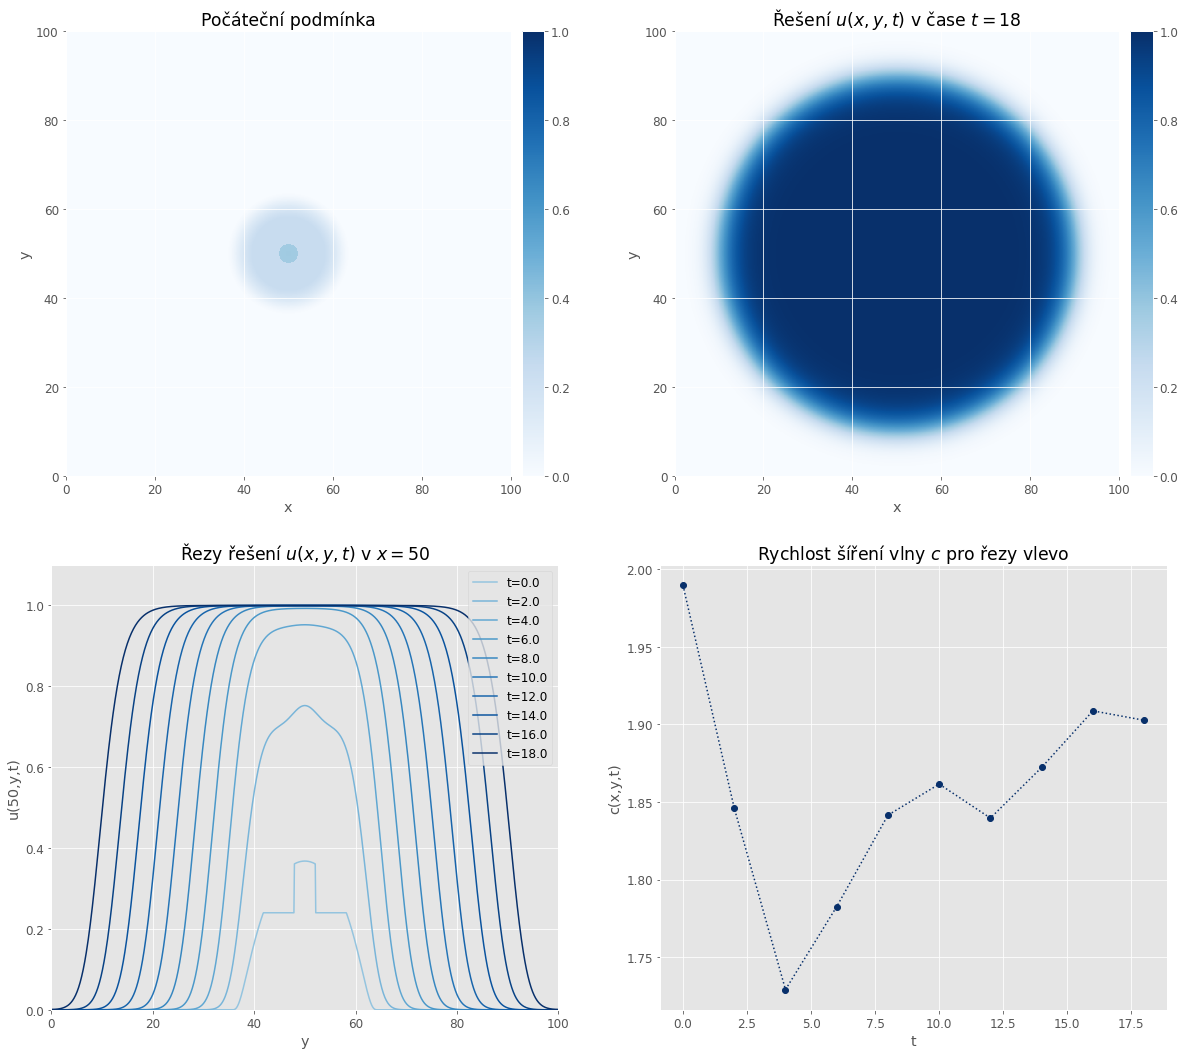

In [6]:
def ivs(x,y):
    c = x**2+y**2
    #print(c)
    if .02 < c < .3:
        return .24
    else:
        return np.exp(-1/(1-x**2-y**2))


result, storage, grid = fksolve(max_time = 18, 
                                iv_func = ivs, 
                                iv_size = 300,
                                grid_size = 1000)


### Bump funkce s radiálně nesymetrickou perturbací

A ještě podobný případ, nentokrát nebude počáteční podmínka ani radiálně symetrická. I v tomto případě se ale řešení vyhladí a je radiálně symetrické. I rychlost šíření takovéto vlny se blíží zespoda k $c \approx 2.$

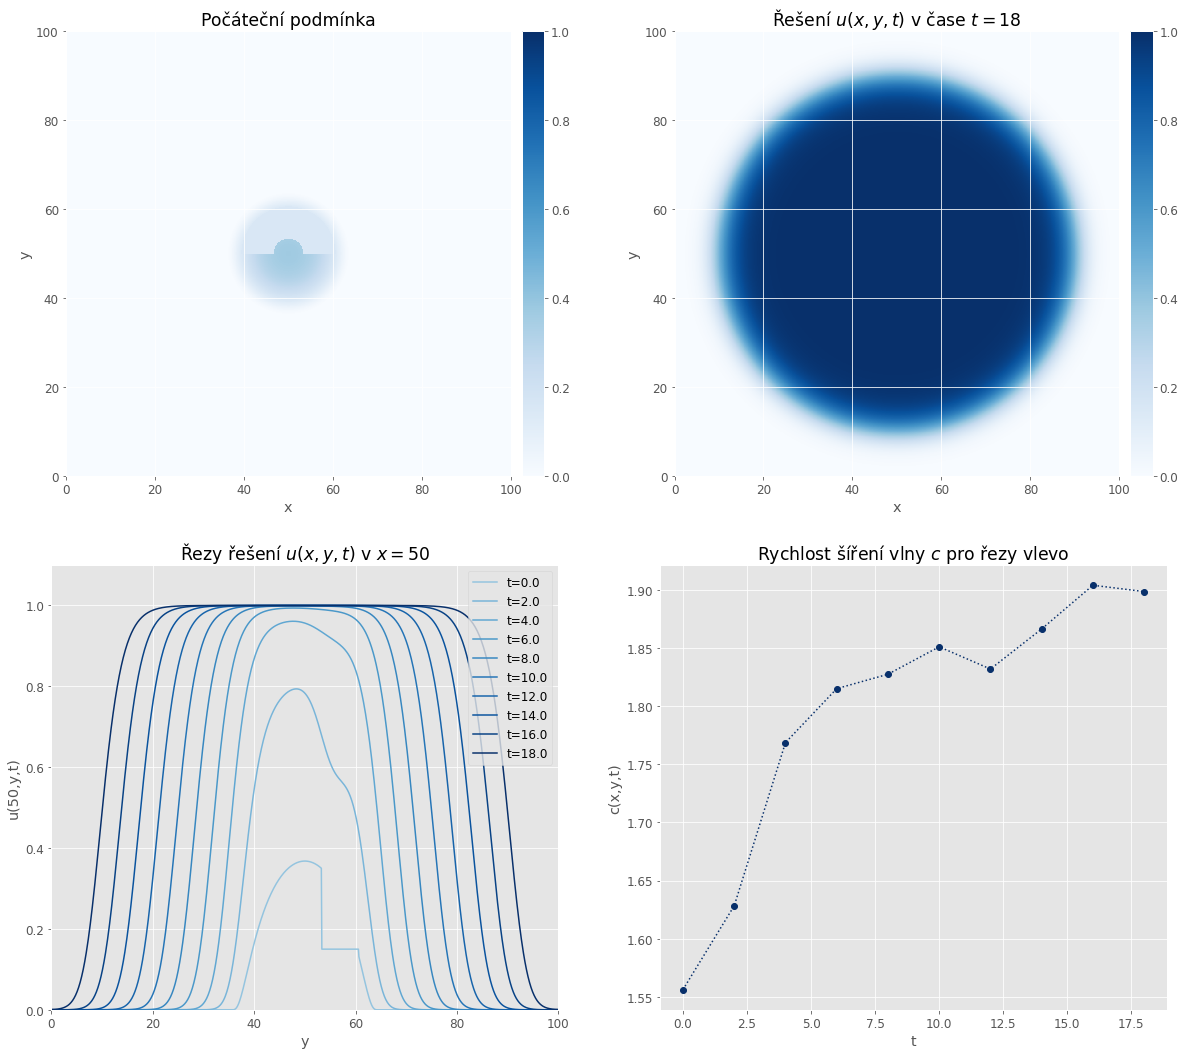

In [7]:
#bump function s NESYMETRICKOU perturbací
def ivs(x,y):
    c = x**2+y**2
    #print(c)
    if (.05 < c < .5) and (y > 0):
        return .15
    else:
        return np.exp(-1/(1-x**2-y**2))


result, storage, grid = fksolve(max_time = 18, 
                                iv_func = ivs, 
                                iv_size = 300,
                                grid_size = 1000,
                                u_level = .1)